In [2]:
import numpy as np
import networkx as nx
import random

class WalkGenerator:
    def __init__(self, graph):  # G是networkx的graph
        self.graph = graph

    def noback_walk(self, walk_length, start_node):
        G = self.graph
        # 默认无向图是连通的, 从任一结点开始出发做RW, 必然能选取邻居结点
        walk = [start_node]   # 添加源结点
        cur_nbrs = list(G.neighbors(start_node))
        walk.append(random.choice(cur_nbrs))  # 添加源结点邻居结点


        while len(walk) < walk_length:
            cur_node = walk[-1]
            last_node = walk[-2]

            cur_nbrs = list(G.neighbors(cur_node))  # cur_nbrs必有last_node

            if len(cur_nbrs) == 1:  # 度为1, cur_nbrs==last_node, 不能继续游走
                break
            else:
                prob_vex = random.choice(cur_nbrs)
                while prob_vex == last_node:
                    prob_vex = random.choice(cur_nbrs)
                walk.append(prob_vex)
                    
        return walk

    def simulate_walks(self, num_walks, walk_length):
        G = self.graph
        nodes = list(G.nodes())
        walks = []

        for i in range(num_walks):
            random.shuffle(nodes)
            for start_node in nodes:
                walks.append(self.noback_walk(walk_length, start_node))
        
        return walks

In [3]:
from gensim.models import Word2Vec

class NoBackWalk:
    def __init__(self, graph, walk_length, num_walks, embed_size):

        self.graph = graph
        self.embed_size = embed_size
        self.em_model = None
        self.embeddings = {}

        self.walker = WalkGenerator(graph)
        self.walks = self.walker.simulate_walks(num_walks
        =num_walks, walk_length=walk_length)

    def train(self, window_size=5, workers=3, epochs=5, **kwargs):
        kwargs["sentences"] = self.walks
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["vector_size"] = self.embed_size
        kwargs["sg"] = 1
        kwargs["hs"] = 0  # not use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["epochs"] = epochs

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs)
        print("Learning embedding vectors done!")

        self.em_model = model

    def get_embeddings(self):
        if self.em_model is None:
            print("model not train")
            return {}

        for node in self.graph.nodes():
            self.embeddings[node] = self.em_model.wv[node]

        return self.embeddings

In [4]:
from scipy import stats
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

block_matrix = np.array([[0.8,0.05,0.05],
                        [0.05,0.8,0.05],
                        [0.05, 0.05, 0.8]])
                        
num_nodes = 90
K = 3    # 社团个数


# 为每个结点分配属于的社团
# 前25个结点属于社团1,中间30个结点属于社团2,后面35个结点属于社团3
group_1 = list(range(25))
group_2 = list(range(25,55))
group_3 = list(range(55,90))

group = [group_1, group_2, group_3]

adj_matrix =  np.zeros((num_nodes, num_nodes), dtype=np.int32)


# 生成无向图邻接矩阵
for i, group_i in enumerate(group):
    for j, group_j in enumerate(group):
        if (j >= i):
            for node_i in group_i:
                for node_j in group_j:
                    adj_matrix[node_i][node_j] = stats.bernoulli.rvs(block_matrix[i][j], random_state=None)

# 再令对角线上元素为0, 无自环
for i in range(num_nodes):
    adj_matrix[i][i] = 0

G = nx.from_numpy_array(adj_matrix)

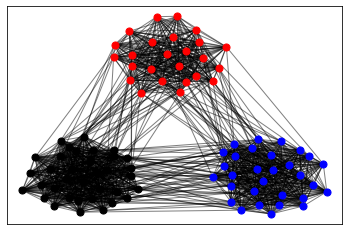

In [5]:
# 可视化
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, group_1, label = True,
node_size = 50, node_color = 'r')
nx.draw_networkx_nodes(G, pos, group_2, node_size = 50,
                            node_color = 'b')
nx.draw_networkx_nodes(G, pos, group_3, node_size = 50,
                            node_color = 'k')

nx.draw_networkx_edges(G, pos, label= True, alpha = 0.5)

plt.show()

In [6]:
model = NoBackWalk(G, walk_length=10, num_walks=80, embed_size=2)
model.train(window_size=5, epochs=3)
embeddings = model.get_embeddings()

Learning embedding vectors...
Learning embedding vectors done!


In [7]:
embeddings

{0: array([ 1.5739859 , -0.33181804], dtype=float32),
 1: array([ 1.7773951, -0.5487832], dtype=float32),
 2: array([ 1.836278  , -0.56271136], dtype=float32),
 3: array([ 1.4817027 , -0.24824245], dtype=float32),
 4: array([ 1.7580645 , -0.51213795], dtype=float32),
 5: array([ 1.5271556, -0.2982162], dtype=float32),
 6: array([ 1.5683626 , -0.31401834], dtype=float32),
 7: array([ 1.8405846, -0.5451728], dtype=float32),
 8: array([ 2.0155544, -0.7269419], dtype=float32),
 9: array([ 1.7105472 , -0.44704533], dtype=float32),
 10: array([ 2.0729287 , -0.75785035], dtype=float32),
 11: array([ 1.8458197, -0.5623734], dtype=float32),
 12: array([ 1.8442708, -0.5609005], dtype=float32),
 13: array([ 1.6438357, -0.4007891], dtype=float32),
 14: array([ 1.5289333 , -0.34105426], dtype=float32),
 15: array([ 1.8287904 , -0.54867554], dtype=float32),
 16: array([ 1.8161638, -0.5648009], dtype=float32),
 17: array([ 1.850113 , -0.5154185], dtype=float32),
 18: array([ 1.5621849, -0.3605911], d